# DiploDatos Kaggle Competition
### Grupo 23

**Integrantes:** Franco Amilcar Genolet (francogeno97@gmail.com), Fabian Alejandro Zapata Cerutti (fzc501@gmail.com), Luis Alejandro Guedez Gomez (luis.guedez@dicsys.com), María Laura Mantovani (mantovanimlaura@gmail.com).

### Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.impute import KNNImputer

from sklearn.tree import DecisionTreeClassifier

### Importación del dataset

In [2]:
df = pd.read_csv('train.csv')

### Exporación y análisis de los datos

In [3]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3430,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,0
1,669,Mars,True,F/126/S,NaN,18.0,False,0.0,0.0,0.0,0.0,0.0,Roswal Sha,1
2,8430,Europa,True,B/343/S,TRAPPIST-1e,33.0,NaN,0.0,0.0,0.0,0.0,0.0,Shaiam Tinganking,1
3,6463,Earth,False,F/1420/P,TRAPPIST-1e,43.0,False,142.0,1208.0,0.0,0.0,204.0,Landa Grifford,0
4,85,Earth,False,G/9/P,TRAPPIST-1e,19.0,False,0.0,0.0,670.0,1.0,34.0,Gracy Dunnisey,0


In [4]:
df.shape

(7823, 14)

Se tiene un dataset con 7.823 registros, 13 variables explicativas y una variable Target (Transported). La descripción de las variables (fuente: [kaggle.com](https://www.kaggle.com/competitions/spaceship-titanic/overview)) es la siguiente:

* PassengerId: Id único por pasajero. 
* HomePlanet: Planeta del cual el pasajero parte, típicamente su planeta de residencia permanente.
* CryoSleep: Indica si el pasajero eligió ser puesto en animación suspendida durante la duración del viaje. Los pasajeros en criosueño están confinados en sus cabinas.
* Cabin: El número de cabina en donde se queda el pasajero. Toma la forma cubierta/número/lado, donde lado puede ser P para babor o S para estribor.
* Destination: El planeta al que desembarcará el pasajero.
* Age: La edad del pasajero.
* VIP: Indica si el pasajero pagó por servicio especial VIP durante el viaje.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: Monto que el pasajero ha facturado en cada uno de los servicios de lujo del Spaceship Titanic.
* Name: Nombre y apellido del pasajero.
* Transported: Indica si el pasajero fue transportado a otra dimensión. Este es el target, la columna que está tratando de predecir.

Veamos ahora cuántos nulos, ceros y valores únicos existen por cada variable, y qué tipo de dato es cada una.

In [5]:
def status(data):
    data2=data
    # total de rows
    tot_rows=len(data2)
    # total de nan
    d2=data2.isnull().sum().reset_index()
    d2.columns=['variable', 'q_nan']
    # percentage of nan
    d2[['p_nan']]=d2[['q_nan']]/tot_rows
    # num of zeros
    d2['q_zeros']=(data2==0).sum().values
    # perc of zeros
    d2['p_zeros']=d2[['q_zeros']]/tot_rows
    # total unique values
    d2['unique']=data2.nunique().values
    # get data types per column
    d2['type']=[str(x) for x in data2.dtypes.values]
    return(d2)
status(df)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,PassengerId,0,0.000000,1,0.000128,7823,int64
1,HomePlanet,179,0.022881,0,0.000000,3,object
2,CryoSleep,196,0.025054,4871,0.622651,2,object
3,Cabin,184,0.023520,0,0.000000,6009,object
4,Destination,160,0.020453,0,0.000000,3,object
5,Age,162,0.020708,160,0.020453,80,float64
6,VIP,184,0.023520,7456,0.953087,2,object
7,RoomService,154,0.019686,5042,0.644510,1195,float64
8,FoodCourt,155,0.019813,4940,0.631471,1400,float64
9,ShoppingMall,188,0.024032,5036,0.643743,1045,float64


PassengerId y Transported son las únicas variables que no tienen faltantes. Veamos cómo se comportan estos faltantes en las otras variables para decidir qué hacer con ellos:

<AxesSubplot:>

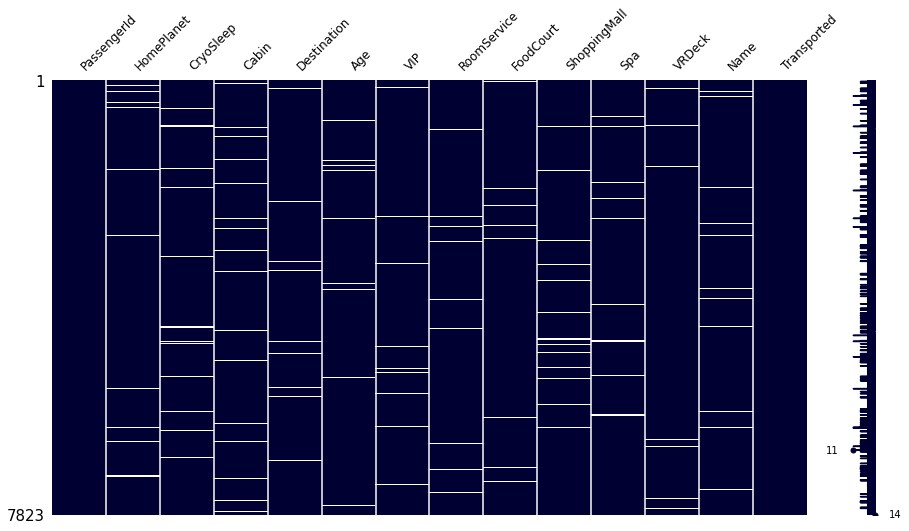

In [6]:
msno.matrix(df,figsize=(15, 8), fontsize=12, color=[0,0,0.2])


Vemos que los datos faltantes son aleatorios y no parecen responder a un problema sistemático. Haremos un análisis exploratorio de las variables antes de comenzar.

Graficamos las variables numéricas con respecto a la variable target:

In [7]:
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

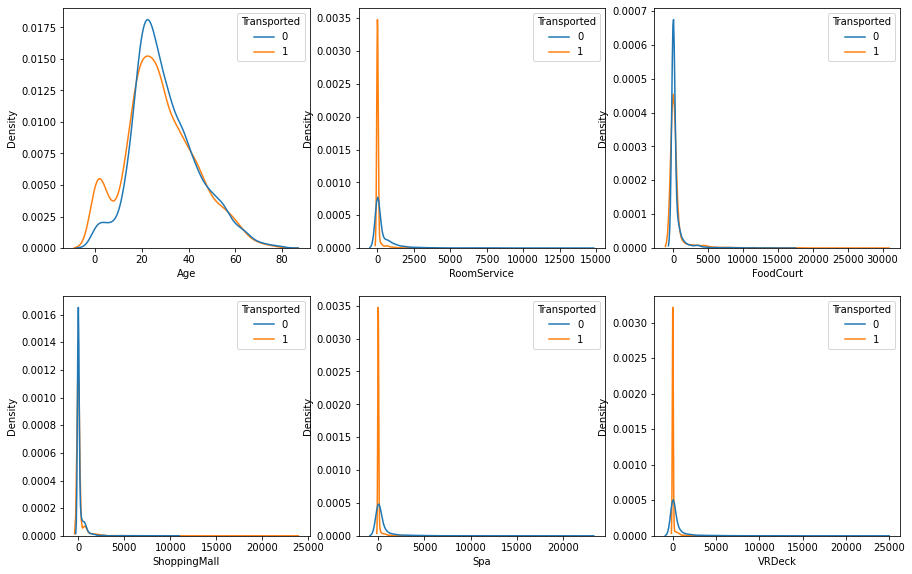

In [8]:
fig = plt.figure(figsize=(15, 15))

for i, coln in enumerate(numerical_cols):
    ax = fig.add_subplot(3,3,i+1)
    sns.kdeplot(data=df, x=coln, hue='Transported')

En cuanto a la edad, se observa que la distribución de los pasajeros transportados se encuentra algo más corrida hacia la izquierda, lo cual podría indicar un grupo más joven. Hay un pequeño salto en la densidad de este grupo cuando los valores son menores 10 aproximadamente. En cuanto a RoomService, FoodCourt, ShoppingMall, Spa, VRDeck (monto facturado en servicios de lujo), las distribuciones estan fuertemente concentradas en el cero. Esto es por el volumen de pasajeros que no facturaron esos servicios. 

Analicemos ahora el boxplot de estas variables en cada grupo para comparar los cuartiles de las respectivas distribuciones:

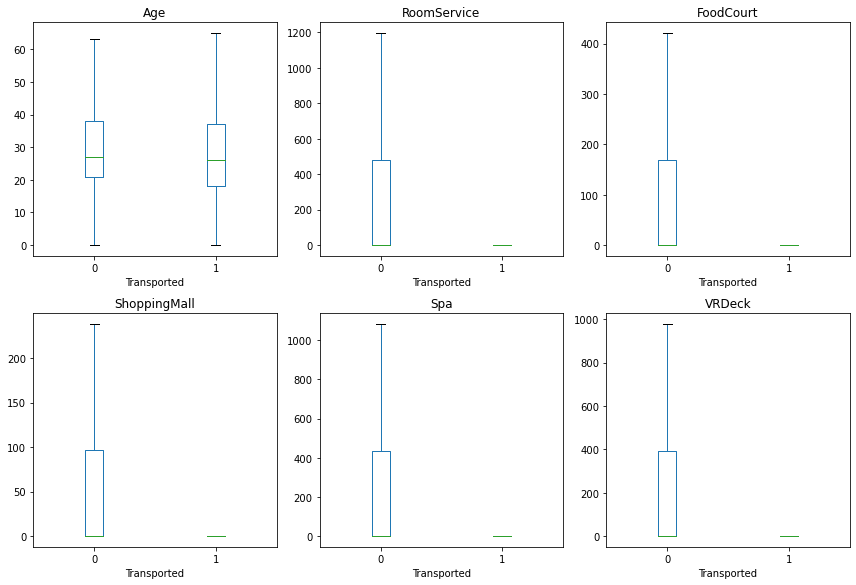

In [9]:
fig = plt.figure(figsize=(12, 12))

for i, coln in enumerate(numerical_cols):
    ax = fig.add_subplot(3,3,i+1)
    df.boxplot(coln, ax=ax, by='Transported',grid=False,showfliers=False);  

fig.suptitle('')
plt.tight_layout()

Como se puede ver en el boxplot, las variables RoomService, FoodCourt, ShoppingMall, Spa, VRDeck (monto facturado en servicios de lujo), tienen mediana cero tanto para el grupo de transportados como para el grupo de no transportados. Sin embargo el grupo de no transportados tiene más datos por encima de esa mediana. A continuación vemos este mismo gráfico pero sin quitar los fliers (valores que se encuentran por fuera de 1.5 por el rango intercuartílico, y podrían considerarse outliers):

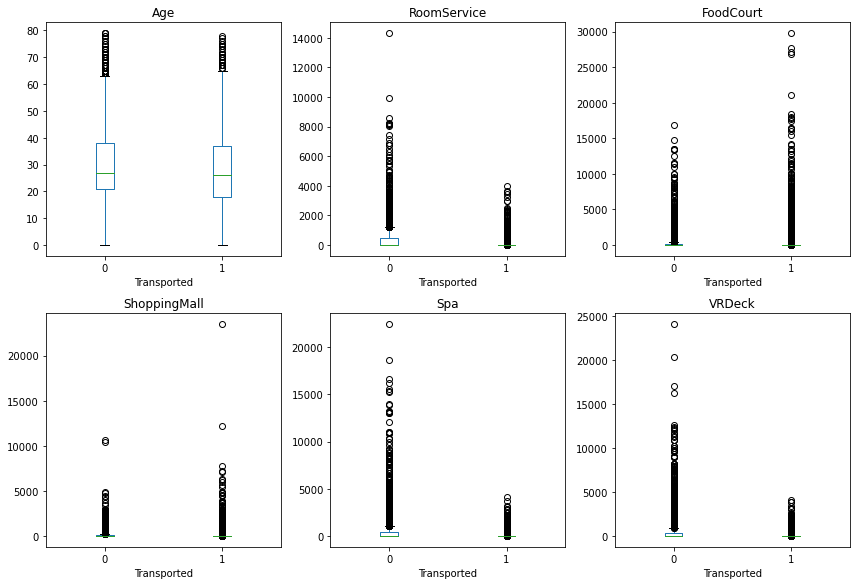

In [10]:
fig = plt.figure(figsize=(12, 12))

for i, coln in enumerate(numerical_cols):
    ax = fig.add_subplot(3,3,i+1)
    df.boxplot(coln, ax=ax, by='Transported',grid=False,showfliers=True);  

fig.suptitle('')
plt.tight_layout()

A continuación se grafican las variables categóricas. Separamos Cabin en 3 para ver también cómo se comportan con respecto a la variable target.

In [11]:
df['CabinDeck'] = df.Cabin.str.rsplit(pat='/', n=3, expand=True )[0]
df['CabinNum'] = df.Cabin.str.rsplit(pat='/', n=3, expand=True )[1].astype(float)
df['CabinSide'] = df.Cabin.str.rsplit(pat='/', n=3, expand=True )[2]

In [12]:
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide']

In [13]:
tr_yes = df[df.Transported == 1]
tr_no = df[df.Transported == 0]

In [14]:
def labeling_yes(val):
    return f'{val / 100 * len(tr_yes):.0f}\n{val:.0f}%'
def labeling_no(val):
    return f'{val / 100 * len(tr_no):.0f}\n{val:.0f}%'

In [15]:
colors = ['seagreen','mediumseagreen','springgreen','lightgreen','darkseagreen','dimgray','whitesmoke']

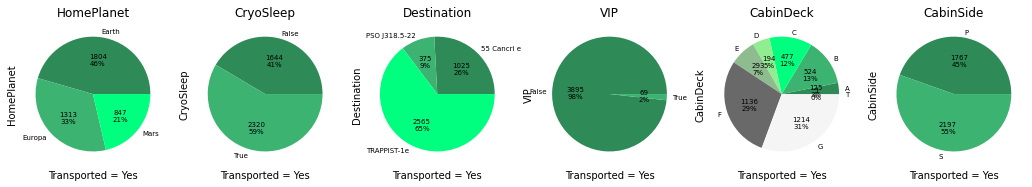

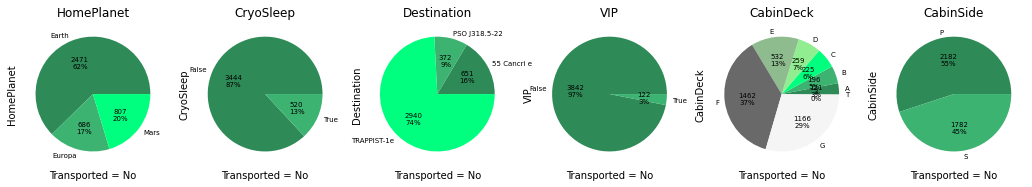

In [16]:
fig1 = plt.figure(figsize=(18, 18))
for i, coln in enumerate(categorical_cols):
    ax1 = fig1.add_subplot(1,len(categorical_cols),i+1)
    ax1.set_title(categorical_cols[i])
    tr_yes.groupby(categorical_cols[i]).size().plot(kind='pie', autopct=labeling_yes, textprops={'fontsize': 7},colors=colors, ax=ax1)
    ax1.set_xlabel('Transported = Yes', size=10)
    ax1.set_ylabel(categorical_cols[i], size=10)

plt.show()
fig2 = plt.figure(figsize=(18, 18))
for i, coln in enumerate(categorical_cols):
    ax2 = fig2.add_subplot(1,len(categorical_cols),i+1)
    ax2.set_title(categorical_cols[i])
    tr_no.groupby(categorical_cols[i]).size().plot(kind='pie', autopct=labeling_yes, textprops={'fontsize': 7},colors=colors, ax=ax2)
    ax2.set_xlabel('Transported = No', size=10)
    ax2.set_ylabel(categorical_cols[i], size=10)

plt.show()

En principio, las variables que en mayor medida muestran distribuciones diferenciadas entre las clases son: CryoSleep y HomePlanet (Europa y Tierra). También puede que Cabin_Side este teniendo alguna influencia. Se codifican también Destination y VIP para terminar de evaluar si serán descartadas o no más adelante.

In [17]:
df['CryoSleep_num']=df.CryoSleep.astype(str).apply(lambda x: 1 if x == 'True' else (0 if x == 'False' else np.nan)) 
df['HomePlanet_num']=df.HomePlanet.apply(lambda x: 1 if x == 'Europa' else (2 if x == 'Earth' else (3 if x == 'Mars' else np.nan))) 
df['CabinSide_num']=df.CabinSide.apply(lambda x: 1 if x == 'S' else 2 if x == 'P' else np.nan) 
df['VIP_num']=df.VIP.astype(str).apply(lambda x: 1 if x == 'True' else 0 if x == 'False' else np.nan) 
df['Destination_num']=df.Destination.apply(lambda x: 1 if x == 'TRAPPIST-1e' else 2 if x == '55 Cancri e' else 3 if x == 'PSO J318.5-22' else np.nan) 

In [18]:
df.describe()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinNum,CryoSleep_num,HomePlanet_num,CabinSide_num,VIP_num,Destination_num
count,7823.000000,7661.000000,7669.000000,7668.000000,7635.000000,7665.000000,7654.000000,7823.000000,7639.000000,7627.000000,7644.000000,7639.000000,7639.000000,7663.000000
mean,4345.691039,28.879389,226.078237,455.643062,172.600393,305.023222,295.476744,0.506711,598.233931,0.361348,1.955521,1.497447,0.023956,1.400496
std,2504.576803,14.461548,679.180148,1621.290107,597.923749,1133.423579,1093.485752,0.499987,511.402123,0.480423,0.678146,0.500026,0.152922,0.654670
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,2182.500000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,1.000000,1.000000,0.000000,1.000000
50%,4345.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,424.000000,0.000000,2.000000,1.000000,0.000000,1.000000
75%,6515.500000,38.000000,44.000000,69.000000,28.000000,58.000000,46.000000,1.000000,992.000000,1.000000,2.000000,2.000000,0.000000,2.000000
max,8692.000000,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,1893.000000,1.000000,3.000000,2.000000,1.000000,3.000000


Definimos un imputador KNN para completar los valores faltantes de las variables continuas usando la técnica del vecino más cercano (k-Nearest Neighbor).

In [19]:
# Hacemos una copia del dataframe para imputar las variables continuas por KNN
df_continuas = df.copy()
df_continuas = df_continuas[['PassengerId','Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Transported']]
imputer_knn = KNNImputer(n_neighbors=2)
df_continuas[df_continuas.columns] = imputer_knn.fit_transform(df_continuas)

In [20]:
status(df_continuas)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,PassengerId,0,0.0,1,0.000128,7823,float64
1,Age,0,0.0,160,0.020453,120,float64
2,RoomService,0,0.0,5141,0.657165,1219,float64
3,FoodCourt,0,0.0,5040,0.644254,1435,float64
4,ShoppingMall,0,0.0,5155,0.658954,1086,float64
5,Spa,0,0.0,4911,0.627764,1275,float64
6,VRDeck,0,0.0,5048,0.645277,1266,float64
7,Transported,0,0.0,3859,0.493289,2,float64


Se imputan las las variables booleanas por la moda (valor más frecuente).

In [21]:
# Hacemos una copia del dataframe para imputar las variables categóricas por su valor más frecuente
df_categoricas = df.copy()
df_categoricas = df_categoricas[['PassengerId','CryoSleep_num','HomePlanet_num','CabinSide_num','VIP_num','Destination_num']]
imputer_mf = SimpleImputer(strategy='most_frequent')
df_categoricas[df_categoricas.columns] = imputer_mf.fit_transform(df_categoricas)

In [22]:
status(df_categoricas)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,PassengerId,0,0.0,1,0.000128,7823,float64
1,CryoSleep_num,0,0.0,5067,0.647705,2,float64
2,HomePlanet_num,0,0.0,0,0.000000,3,float64
3,CabinSide_num,0,0.0,0,0.000000,2,float64
4,VIP_num,0,0.0,7640,0.976607,2,float64
5,Destination_num,0,0.0,0,0.000000,3,float64


Unimos las columnas imputadas en un dataframe, y verificamos que no haya nulos

In [23]:
df_imputed = df_continuas
df_imputed = df_continuas.set_index('PassengerId').join(df_categoricas.set_index('PassengerId')).reset_index()
status(df_imputed)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,PassengerId,0,0.0,1,0.000128,7823,float64
1,Age,0,0.0,160,0.020453,120,float64
2,RoomService,0,0.0,5141,0.657165,1219,float64
3,FoodCourt,0,0.0,5040,0.644254,1435,float64
4,ShoppingMall,0,0.0,5155,0.658954,1086,float64
5,Spa,0,0.0,4911,0.627764,1275,float64
6,VRDeck,0,0.0,5048,0.645277,1266,float64
7,Transported,0,0.0,3859,0.493289,2,float64
8,CryoSleep_num,0,0.0,5067,0.647705,2,float64
9,HomePlanet_num,0,0.0,0,0.000000,3,float64


Separamos las variables explicativas (X) de nuestra variable TARGET (y):

In [24]:
X = df_imputed.drop('Transported', axis=1)
y = df_imputed.Transported

Text(0.5, 1.0, 'Correlation between Variables')

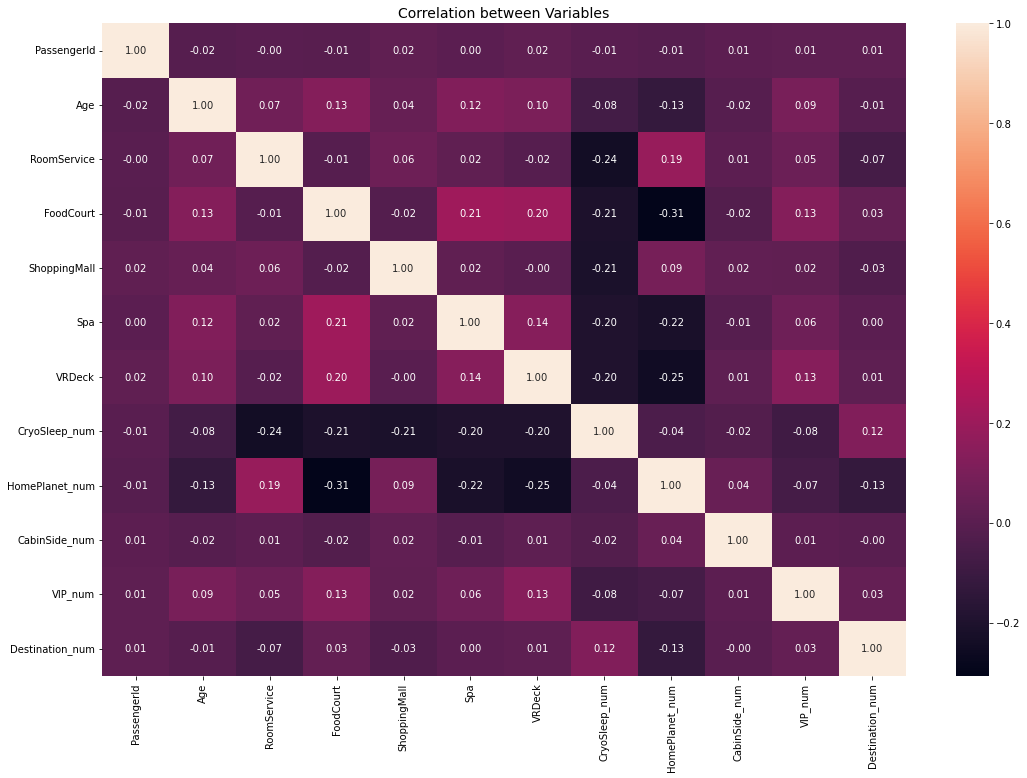

In [25]:
# Revisamos que no haya una correlación fuerte entre nuestras variables explicativas
plt.figure(figsize=(18,12))
sns.heatmap(X.corr(),annot=True, fmt='.2f')
plt.title('Correlation between Variables', fontsize=14)

In [26]:
# Escalamos
x_names = X.columns
scaler = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
X_orig = X.copy(deep=True)
X = scaler.fit_transform(X_orig)
X = pd.DataFrame(X, columns=x_names)
X

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep_num,HomePlanet_num,CabinSide_num,VIP_num,Destination_num
0,0.394616,0.721519,0.000000,0.129440,0.000553,0.008702,0.160527,0.0,0.0,1.0,0.0,0.0
1,0.076967,0.227848,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0
2,0.969857,0.417722,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0
3,0.743557,0.544304,0.009911,0.040519,0.000000,0.000000,0.008453,0.0,0.5,1.0,0.0,0.0
4,0.009779,0.240506,0.000000,0.000000,0.028520,0.000045,0.001409,0.0,0.5,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7818,0.751035,0.151899,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0
7819,0.309825,0.556962,0.000000,0.000000,0.031670,0.002767,0.000124,0.0,0.5,0.0,0.0,0.0
7820,0.929130,0.696203,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.0,0.0
7821,0.440520,0.189873,0.000000,0.028176,0.005236,0.000000,0.000829,0.0,0.5,1.0,0.0,0.0


### Entrenamiento y Test

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 8)

### Modelos

In [28]:
#ACA VA LO DE ALE/FRANCO

### Algún tipo de ajuste de hiperparámetros de los modelos elegidos

In [29]:
#ACA VA LO DE ALE/FRANCO
#ABAJO YA DEJÉ EL CÓDIGO PARA LA PARTE DE LA SALIDA, HAY QUE REVISAR ABAJO QUE PARA LA PREDICCIÓN USE EL MODELO GANADOR

## Generar la salida para entregar

In [30]:
test_df = pd.read_csv('test.csv')

In [31]:
test_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,415,Europa,True,NaN,55 Cancri e,34.0,False,0.0,0.0,0.0,0.0,0.0,Minopus Taptiritty
1,8663,Earth,True,G/1489/S,PSO J318.5-22,13.0,False,0.0,0.0,0.0,0.0,0.0,Chrisa Francock
2,4524,Earth,False,G/776/P,TRAPPIST-1e,44.0,False,22.0,1.0,0.0,864.0,0.0,Elinda Miley
3,8246,Earth,False,E/577/S,PSO J318.5-22,63.0,False,0.0,0.0,80.0,0.0,2322.0,Karley Goods
4,2935,Europa,False,B/117/S,55 Cancri e,10.0,False,0.0,0.0,0.0,0.0,0.0,Arkard Sechausive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,5996,Mars,False,F/1212/S,TRAPPIST-1e,54.0,False,676.0,0.0,231.0,379.0,0.0,Anch Perta
866,5478,Earth,True,G/947/S,TRAPPIST-1e,58.0,False,0.0,0.0,0.0,0.0,0.0,Hughy Hessey
867,6760,Earth,True,G/1148/P,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Heidie Kimpson
868,1437,Earth,False,F/293/S,TRAPPIST-1e,18.0,False,765.0,0.0,13.0,0.0,0.0,Herina Oconley


Para poder evaluar nuestra predicción los datos de prueba deben tener exactamente el mismo tratamiento que los datos de entrenamiento

In [32]:
test_df['CabinDeck'] = test_df.Cabin.str.rsplit(pat='/', n=3, expand=True )[0]
test_df['CabinNum'] = test_df.Cabin.str.rsplit(pat='/', n=3, expand=True )[1].astype(float)
test_df['CabinSide'] = test_df.Cabin.str.rsplit(pat='/', n=3, expand=True )[2]

# codificamos
test_df['CryoSleep_num']=test_df.CryoSleep.astype(str).apply(lambda x: 1 if x == 'True' else (0 if x == 'False' else np.nan)) 
test_df['HomePlanet_num']=test_df.HomePlanet.apply(lambda x: 1 if x == 'Europa' else (2 if x == 'Earth' else (3 if x == 'Mars' else np.nan))) 
test_df['CabinSide_num']=test_df.CabinSide.apply(lambda x: 1 if x == 'S' else 2 if x == 'P' else np.nan) 
test_df['VIP_num']=test_df.VIP.astype(str).apply(lambda x: 1 if x == 'True' else 0 if x == 'False' else np.nan) 
test_df['Destination_num']=test_df.Destination.apply(lambda x: 1 if x == 'TRAPPIST-1e' else 2 if x == '55 Cancri e' else 3 if x == 'PSO J318.5-22' else np.nan) 

# imputamos
test_df_continuas = test_df.copy()
test_df_continuas = test_df_continuas[['PassengerId','Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
test_df_continuas[test_df_continuas.columns] = imputer_knn.fit_transform(test_df_continuas)

test_df_categoricas = test_df.copy()
test_df_categoricas = test_df_categoricas[['PassengerId','CryoSleep_num','HomePlanet_num','CabinSide_num','VIP_num','Destination_num']]
test_df_categoricas[test_df_categoricas.columns] = imputer_mf.fit_transform(test_df_categoricas)

# unimos el resultado
test_df_imputed = test_df_continuas.set_index('PassengerId').join(test_df_categoricas.set_index('PassengerId')).reset_index()
status(test_df_imputed)


,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,PassengerId,0,0.0,0,0.000000,870,float64
1,Age,0,0.0,18,0.020690,82,float64
2,RoomService,0,0.0,549,0.631034,248,float64
3,FoodCourt,0,0.0,537,0.617241,267,float64
4,ShoppingMall,0,0.0,561,0.644828,223,float64
5,Spa,0,0.0,517,0.594253,269,float64
6,VRDeck,0,0.0,564,0.648276,234,float64
7,CryoSleep_num,0,0.0,589,0.677011,2,float64
8,HomePlanet_num,0,0.0,0,0.000000,3,float64
9,CabinSide_num,0,0.0,0,0.000000,2,float64


Generamos la salida

In [33]:
test_id = test_df_imputed.PassengerId
#test_pred = clf.predict(test_df) #---> REEMPLAZAR "CLF" POR EL NOMBRE QUE TENGA EL MODELO GANADOR

In [34]:
#submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["PassengerId", "Transported"])
#submission.to_csv("sample_submission.csv", header=True, index=False)